# Image Analysis And Recognition - Homework
---
* <a href='#hw1'>Homework.1 - Image Averaging</a>
* <a href='#hw2'>Homework.2 - Imgae Stitching</a>
* <a href='#hw3'>Homework.3 - Edge Detection</a>
* <a href='#hw4'>Homework.4 - Money Classification</a>

In [1]:
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from skimage.data import camera
from skimage.filters import sobel
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler

In [2]:
def print_image(image, title=""):
    fig = plt.figure()
    fig.set_size_inches((10, 6))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

# <a name='hw1'>Homework.1 - Image Averaging</a>
---
### 運算步驟:
1. 定義產生椒鹽雜訊的函式: sp_noise
2. 讀取原圖 (img)
3. 依據原圖產生3張含有隨機椒鹽雜訊的圖片列表 (img_list)
4. 印出三張圖片取平均後結果
5. 印出三張圖片取中位數的結果

In [3]:
def sp_noise(image,prob):
    '''
    salt and pepper noise 椒鹽雜訊
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

def avg_image(image_list):
    '''
    calculate average 取平均
    '''
    return np.sum(image_list, 0)/len(image_list)

def med_image(image_list):
    '''
    calculate median 取中位數
    '''
    return np.median(image_list, 0)

### 讀取原圖，並把channel順序BGR反向排序成RGB

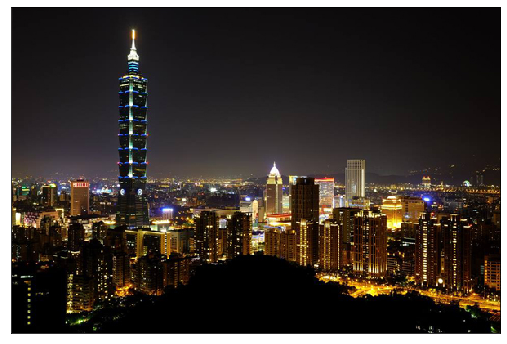

In [4]:
img = cv2.imread('101view.jpg')[:,:,::-1]
print_image(img)

### 生成三張有隨機椒鹽雜訊圖片的列表，並印出其中一張

length of img_list:3


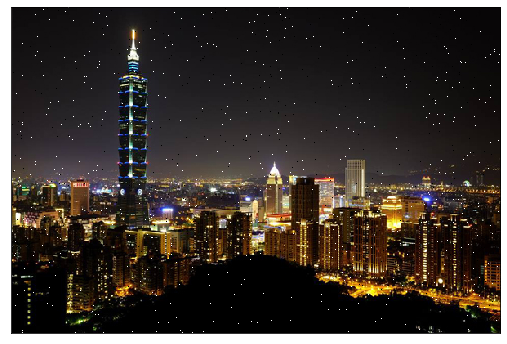

In [5]:
img_list = [sp_noise(img, 0.001*i) for i in range(1,4)]
print(f'length of img_list:{len(img_list)}')
print_image(img_list[2])

### 印出三張圖片取平均的結果
---
仍然看得到有一些白點

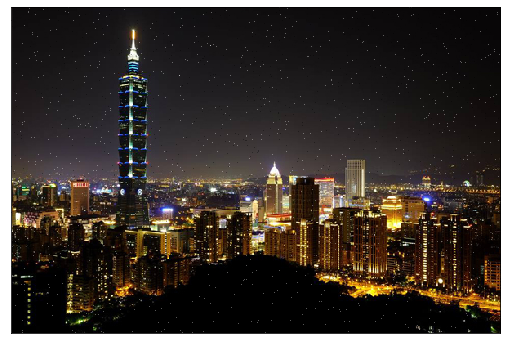

In [6]:
print_image(avg_image(img_list).astype(np.uint8))

### 印出三張圖片取中位數的結果
---
在隨機雜訊上，除噪表現較平均來得好

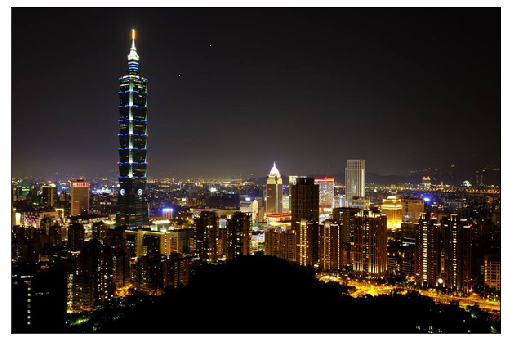

In [7]:
print_image(med_image(img_list).astype(np.uint8))

# <a name='hw2'>Homework.2 - Image Stitching</a>
---
### 運算步驟:
1. 讀取欲拼接的圖片2張 (img_s1、img_s2)
2. 印出2張圖片，並手動標記欲配對的3個座標點
3. 計算轉換矩陣: get_affine，用3個點解6個變數 (t11、t21、t31、t12、t22、t32)  
    (1) 227 = t11 * 26 + t21 * 230 + t31  
    (2) 230 = t12 * 26 + t22 * 230 + t32  
    (3) 440 = t11 * 190 + t21 * 142 + t31  
    (4) 145 = t12 * 190 + t22 * 142 + t32  
    (5) 478 = t11 * 229 + t21 * 297 + t31  
    (6) 478 = t12 * 229 + t22 * 297 + t32  
4. 宣告黑色畫布，先把 img_s1 先疊上去
5. 把 img_s2 的四個角找出來，再把邊畫出來
6. 畫出 img_s2 在畫布坐標系中的部分投影 (Inverse Mapping)

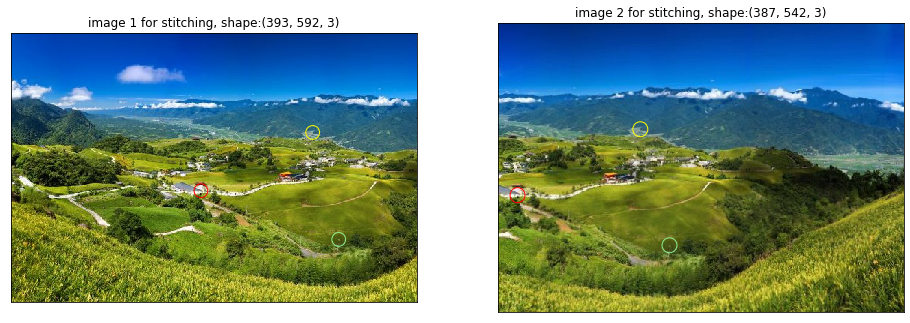

In [8]:
img_s1 = cv2.imread('img_s1.jpg')[:,:,::-1]
img_s2 = cv2.imread('img_s2.jpg')[:,:,::-1]

fig = plt.figure(figsize=(16,10))

circle11 = plt.Circle((277, 230), 10, color='r', fill=False)
circle12 = plt.Circle((440, 145), 10, color='yellow', fill=False)
circle13 = plt.Circle((478, 301), 10, color='lightgreen', fill=False)
ax1 = fig.add_subplot(121)
plt.imshow(img_s1)
plt.xticks([])
plt.yticks([])
ax1.add_artist(circle11)
ax1.add_artist(circle12)
ax1.add_artist(circle13)
plt.title(f'image 1 for stitching, shape:{img_s1.shape}')
    
circle21 = plt.Circle((26, 230), 10, color='r', fill=False)
circle22 = plt.Circle((190, 142), 10, color='yellow', fill=False)
circle23 = plt.Circle((229, 297), 10, color='lightgreen', fill=False)
ax2 = fig.add_subplot(122)
plt.imshow(img_s2)
plt.xticks([])
plt.yticks([])
ax2.add_artist(circle21)
ax2.add_artist(circle22)
ax2.add_artist(circle23)
plt.title(f'image 2 for stitching, shape:{img_s2.shape}')
plt.show()

### 列出6個點的座標，要用來計算轉換矩陣

In [9]:
primary = np.array([[277, 230], [440, 145], [478, 301]], dtype=np.float64)

secondary = np.array([[26, 230], [190, 142], [229, 297]], dtype=np.float64)

### 計算 Affine Transformation 矩陣

In [10]:
def get_affine(from_p, to_p):
    cm = np.array([[from_p[0,0], from_p[0,1], 1], [from_p[1,0], from_p[1,1], 1], [from_p[2,0], from_p[2,1], 1]])
    b_tx1 = np.array([to_p[0,0], to_p[1,0], to_p[2,0]])
    b_tx2 = np.array([to_p[0,1], to_p[1,1], to_p[2,1]])
    Af_tx1 = np.linalg.solve(cm, b_tx1)
    Af_tx2 = np.linalg.solve(cm, b_tx2)
    return np.array([[Af_tx1[0], Af_tx2[0], 0], [Af_tx1[1], Af_tx2[1], 0], [Af_tx1[2], Af_tx2[2], 1]])

### 從 img_s2 座標轉到 img_s1 座標的轉換矩陣: Af21

In [11]:
Af21 = get_affine(secondary, primary)
Af21

array([[ 9.91577707e-01,  1.91667822e-02,  0.00000000e+00],
       [-4.33245529e-03,  1.00162900e+00,  0.00000000e+00],
       [ 2.52215444e+02, -8.73007071e-01,  1.00000000e+00]])

### 從 img_s1 座標轉到 img_s2 座標的轉換矩陣: Af12

In [12]:
Af12 = get_affine(primary, secondary)
Af12

array([[ 1.00840952e+00, -1.92965315e-02,  0.00000000e+00],
       [ 4.36178380e-03,  9.98290181e-01,  0.00000000e+00],
       [-2.54332647e+02,  5.73839766e+00,  1.00000000e+00]])

### 宣告黑底色畫布，把 img_s1 疊上去

In [13]:
canvas = np.zeros([500, 1000, 3], dtype=np.uint8)
canvas[50:393+50, 50:592+50, :] = img_s1

### 把 img_s2 四個角落找出來

In [14]:
c1 = np.dot([0, 0, 1], Af21) #左上角
c2 = np.dot([0, 393, 1], Af21) #右上角
c3 = np.dot([592, 0, 1], Af21) #左下角
c4 = np.dot([592, 393, 1], Af21) #右下角

In [15]:
p1 = np.array([c1[0], c1[1]]) + 50
p2 = np.array([c2[0], c2[1]]) + 50
p3 = np.array([c3[0], c3[1]+50])
p4 = np.array([c4[0], c4[1]+50])

### 畫出 img_s2 在畫布坐標系中的部分投影 (Inverse Mapping)

In [16]:
d1, d2, _ = img_s2.shape
for i in range(50,600):
    for j in range(642,900):
        ctx = np.dot([j-50, i-50, 1], Af12)
        ctx1 = int(ctx[1])
        ctx0 = int(ctx[0])
        if ((ctx1 < d1) & (ctx0 < d2) & (ctx1 >= 0) & (ctx0 >= 0)):
            canvas[i, j, :] = img_s2[ctx1, ctx0, :] # nearest neighbor interpolation
        # 如果要做 Bilinear interpolation 的話，要多加一個function
        # canvas[i, j, :] = get_bilinear_pixel_value(img_s2, ctx[1], ctx[0])

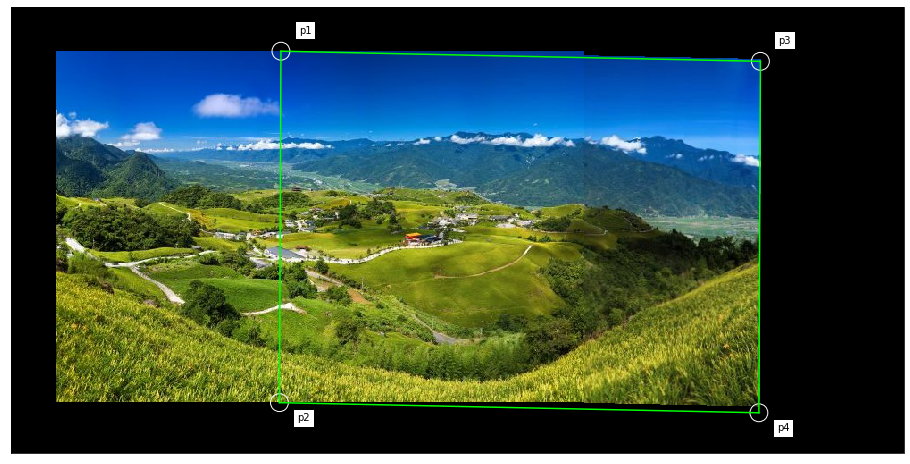

In [17]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
plt.xticks([])
plt.yticks([])
circle1 = plt.Circle((p1[0], p1[1]), 10, color='w', fill=False)
circle2 = plt.Circle((p2[0], p2[1]), 10, color='w', fill=False)
circle3 = plt.Circle((p3[0], p3[1]), 10, color='w', fill=False)
circle4 = plt.Circle((p4[0], p4[1]), 10, color='w', fill=False)
plt.text(p1[0]+20, p1[1]-20, 'p1', bbox=dict(facecolor='w'))
plt.text(p2[0]+20, p2[1]+20, 'p2', bbox=dict(facecolor='w'))
plt.text(p3[0]+20, p3[1]-20, 'p3', bbox=dict(facecolor='w'))
plt.text(p4[0]+20, p4[1]+20, 'p4', bbox=dict(facecolor='w'))
ax.add_line(mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='lime'))
ax.add_line(mlines.Line2D([p2[0],p4[0]], [p2[1],p4[1]], color='lime'))
ax.add_line(mlines.Line2D([p4[0],p3[0]], [p4[1],p3[1]], color='lime'))
ax.add_line(mlines.Line2D([p3[0],p1[0]], [p3[1],p1[1]], color='lime'))
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
plt.imshow(canvas)

# <a name='hw3'>Homework.3 - Edge Detection</a>
---
### 運算步驟:
1. 讀取原圖 (img_cvo)
2. 計算原圖與二階微分 Laplacian mask 的卷積運算結果 (img_cvo2)
3. 計算原圖與 Sobel filters 的卷積運算結果 (img_cvo3)
4. 計算 img_cvo3 與Average Filter的卷積運算結果 (img_cvo4)
5. 將 img_cvo4 正規化 (0 ~ 1) (img_cvo5)
6. 計算 img_cvo5 與原圖相乘 (img_cvo6)
7. 將 img_cvo6 加上原圖 (img_cvo7)

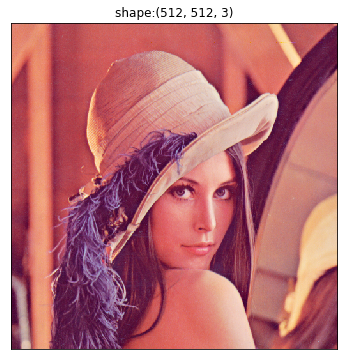

In [18]:
img_cvo = cv2.imread('Lenna.png')[:,:,::-1]
print_image(img_cvo, f'shape:{img_cvo.shape}')

### 定義 filters

In [19]:
# sobel filters
sobel_h = np.array([[ 1,  2,  1], 
                    [ 0,  0,  0], 
                    [-1, -2, -1]], dtype=np.float)

sobel_v = np.array([[1, 0, -1], 
                    [2, 0, -2], 
                    [1, 0, -1]], dtype=np.float)

# average filter
avg_flt = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]], dtype=np.float)

#sharpening filters
sharp_flt_1 = np.array([[0, -1, 0],
                        [-1, 4, -1],
                        [0, -1, 0]], dtype=np.float)

sharp_flt_2 = np.array([[-1, -1, -1],
                        [-1,  8, -1],
                        [-1, -1, -1]], dtype=np.float)

In [20]:
def convolution(image, filt, devide_by=1, padding=True):
    result = np.zeros_like(image)
    
    if(padding):
        image_p = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    else:
        image_p = image
        
    uh, uw, uc = image_p.shape
    for c in range(uc):
        for i in range(1,uh-1):
            for j in range(1,uw-1):
                pixel_value = (image_p[i-1:i+2, j-1:j+2, c] * filt).sum() / devide_by
                result[i-1, j-1, c] = np.clip(pixel_value, 0, 255)

    return result

### 計算原圖與二階sharpen filter的卷積運算
---
可觀察到雜訊也被放大

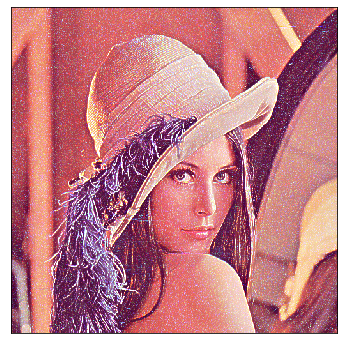

In [40]:
img_cvo2 = cv2.add(convolution(img_cvo, sharp_flt_2), img_cvo)
print_image(img_cvo2)

### 計算原圖與sobel filters的卷積運算

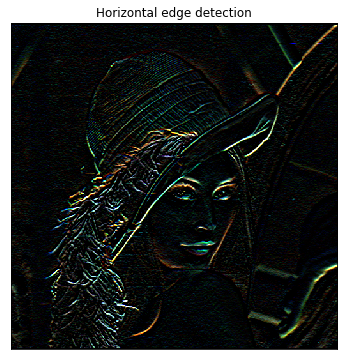

In [42]:
# Horizontal edge detection
img_h = convolution(img_cvo, sobel_h)
print_image(img_h, 'Horizontal edge detection')

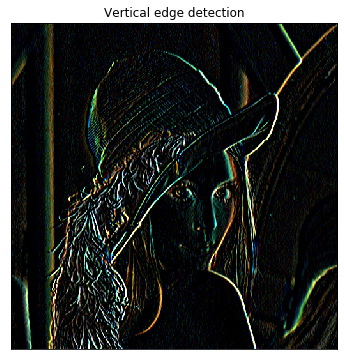

In [43]:
# Vertical edge detection
img_v = convolution(img_cvo, sobel_v)
print_image(img_v, 'Vertical edge detection')

### 水平邊緣 + 垂直邊緣

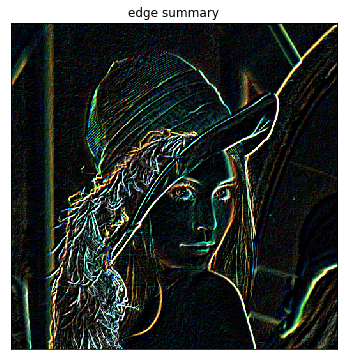

In [44]:
img_cvo3 = cv2.add(img_h, img_v)
print_image(img_cvo3, 'edge summary')

### 平均濾波器

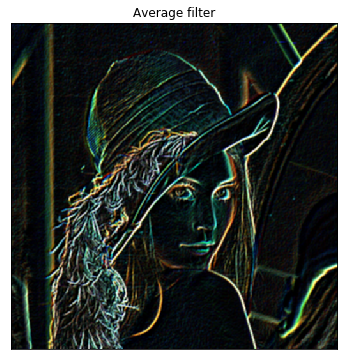

In [45]:
img_cvo4 = convolution(img_cvo3, avg_flt, 9)
print_image(img_cvo4, 'Average filter')

### 資料正規化 (0 ~ 1)

In [26]:
img_cvo5 = (img_cvo4 - np.min(img_cvo4)) / (np.max(img_cvo4) - np.min(img_cvo4))
print(f'min:{np.min(img_cvo5)}, max:{np.max(img_cvo5)}')

min:0.0, max:1.0


### 與原圖相乘

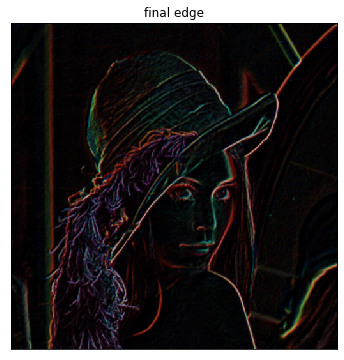

In [46]:
img_cvo6 = (img_cvo5 * img_cvo).astype(np.uint8)
print_image(img_cvo6, 'final edge')

### 效果展示

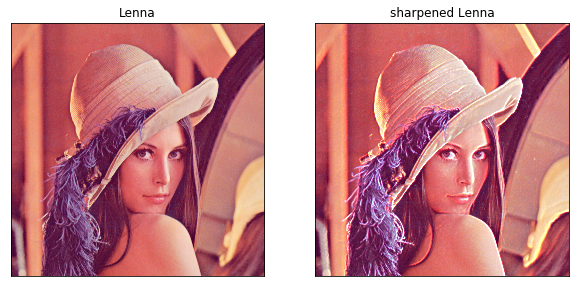

In [28]:
fig = plt.figure()
fig.set_size_inches((10, 6))

ax1 = fig.add_subplot(121)
plt.imshow(img_cvo)
plt.xticks([])
plt.yticks([])
plt.title('Lenna')

ax2 = fig.add_subplot(122)
plt.imshow(cv2.add(img_cvo, img_cvo6))
plt.xticks([])
plt.yticks([])
plt.title('sharpened Lenna')

plt.show()

# <a name='hw4'>Homework.4 - Money Classification</a>
---
1. Data Augmentation
2. Dropout
3. Transfer Learning

In [29]:
import glob
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # use GPU

In [30]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Flatten, GlobalAveragePooling2D)
import tensorflow as tf

In [31]:
root = 'money'
list_class = ['100', '500', '1000']
num_class = 3

data_bucket = {list_class[i]:[] for i in range(num_class)}
for c in list_class:
    files = list(glob.glob(os.path.join(root, c, "*.jpg")))
    for file_path in files:
        key = c
        value = file_path
        data_bucket[key].append(value)

# Random sampling
---
* train_size: 每個類別取 train_size 張圖片來當訓練資料
* valid_size: 每個類別取 valid_size 張圖片來當驗證資料
* repeatable: 抽樣是否可重複

In [32]:
def sample(train_size, valid_size, repeatable=False):
    train_samples = pd.DataFrame(columns=['img_path', 'label'])
    valid_samples = pd.DataFrame(columns=['img_path', 'label'])

    for clab in list_class:
        random.shuffle(data_bucket[clab])
        # 每個類別隨機抽樣 train_size 筆
        data1 = pd.DataFrame(data={'img_path': data_bucket[clab][:train_size], 'label': clab})
        train_samples = pd.concat([train_samples, data1], ignore_index = True)
        
        # 每個類別隨機抽樣 valid_size 筆
        if (repeatable):
            shuffled_list = random.shuffle(data_bucket[clab])
            data2 = pd.DataFrame(data={'img_path': data_bucket[clab][:valid_size], 'label': clab})
            valid_samples = pd.concat([valid_samples, data2], ignore_index = True)
        else:
            data2 = pd.DataFrame(data={'img_path': data_bucket[clab][train_size:train_size+valid_size], 'label': clab})
            valid_samples = pd.concat([valid_samples, data2], ignore_index = True)
    
    return train_samples, valid_samples

# Import Pre-trained Model (Transfer Learning)
---
* 使用ResNet50來建模
* 加入一Dropout層

In [33]:
from tensorflow.keras.applications.resnet import (ResNet50, preprocess_input)

In [34]:
def create_model():
    pre_model = ResNet50(weights='imagenet', include_top=False,
                     input_shape=(img_size, img_size, 3))
    pre_model.trainable = True
    
    x = GlobalAveragePooling2D()(pre_model.output)
    x = Dropout(0.4)(x)
    outputs = Dense(num_class, activation='softmax')(x)

    return Model(inputs=pre_model.inputs, outputs=outputs)

# Data Augmentation
---
* train_datagen: 用變形過的圖片來訓練
* valid_datagen: 用沒變形過的資料來做驗證

In [35]:
train_datagen = ImageDataGenerator(
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=40,
                                   shear_range=0.1, # 剪切
                                   zoom_range=0.5, # 縮放
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest' ,
                                   preprocessing_function=preprocess_input
                                  )
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Get data generators
---
每次產生都要隨機抽樣不同樣本

In [36]:
train_list, valid_list = [], []

In [37]:
data_path='.'
img_size = 224
batch_size = 32
img_shape = (img_size, img_size)

def get_generator():
    train_list, valid_list = sample(15, 5)
    train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

    valid_generator = valid_datagen.flow_from_dataframe(
                                                    dataframe=valid_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)
    
    return train_generator, valid_generator

# Training model
---
開始模型訓練

Found 45 validated image filenames belonging to 3 classes.
Found 15 validated image filenames belonging to 3 classes.
Epoch 1/20
2/2 [==============================] - 3s 2s/step - loss: 1.4254 - accuracy: 0.3333 - val_loss: 1.2269 - val_accuracy: 0.5333
Epoch 2/20
2/2 [==============================] - 1s 367ms/step - loss: 1.0579 - accuracy: 0.5778 - val_loss: 1.0366 - val_accuracy: 0.6000
Epoch 3/20
2/2 [==============================] - 1s 497ms/step - loss: 0.8082 - accuracy: 0.6889 - val_loss: 0.9429 - val_accuracy: 0.6667
Epoch 4/20
2/2 [==============================] - 1s 435ms/step - loss: 0.6548 - accuracy: 0.7778 - val_loss: 0.7890 - val_accuracy: 0.7333
Epoch 5/20
2/2 [==============================] - 1s 419ms/step - loss: 0.3266 - accuracy: 0.8667 - val_loss: 0.6612 - val_accuracy: 0.8000
Epoch 6/20
2/2 [==============================] - 1s 433ms/step - loss: 0.2504 - accuracy: 0.9333 - val_loss: 0.5577 - val_accuracy: 0.8000
Epoch 7/20
2/2 [=============================

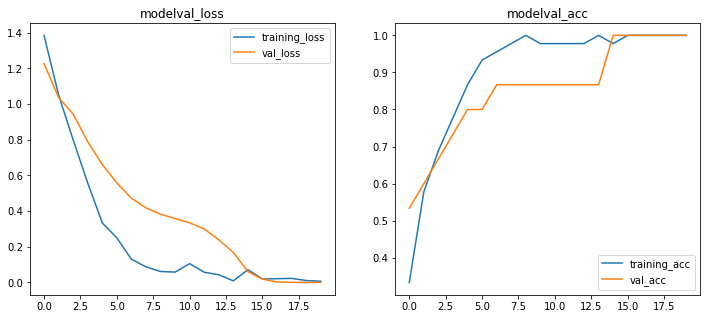

In [38]:
#num_steps = len(train_list) // batch_size + 1
num_epochs = 20

learning_rate = 1e-4
optimizer = keras.optimizers.Adam(lr=learning_rate)


# new model
model = None
model = create_model()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# fit model
train_generator, valid_generator = get_generator()
history = model.fit_generator(train_generator,
                              epochs=num_epochs,
                              validation_data=valid_generator)
    
# results
y_pred = model.predict_generator(valid_generator)
y_pred = y_pred.argmax(-1)
class_name = valid_generator.class_indices
    
# 視覺化
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model'+eachy)
plt.show()